## RLab 3

In this RLab assignment, we will use the k-nearest neighbors (knn) algorithm to classify and predict new observations with their proximity to k most-similar observations from training data. In the case of categorical target variable, we use classification method by using the majority rule in K- nearest neighbors.  If, on the other hand, we have a numerical target variable, then it is considered as a regression problem and we use the mean value in the K- nearest neighbors.  When it comes to distance measurement, the most commonly used distance measures are Euclidean, Manhattan, and Minkowski distances. 




##  Credit Data 


We will use the credit data from RLab 2 to identify whether a customer is risky or not in terms of repaying the loan. But, this time, instead of logistic regression, we will classify customers based on the knn algorithm and only use 4 predictors from the list.  The dataset is in csv format, we read the data with read.csv command in R.   

The Credit dataset includes the following variables:
- **creditability**:  Credit risk, Good (1), Bad (0)  (This is our target variable.)
- **payment_status**: Payment Status of Previous Credit. Unknown (0), Some Problems (1), Paid Up (2), No Problems (in this bank) (3),  No Problems (in all banks) (4)
- **credit_amount**: current amount of credit from other accounts
- **sex_marital**: Sex and marital status: Male Divorced/Single (1), Male Married/Widowed (2), Female  Married/Widowed  (3), Female Divorced/Single (4)
- **age**: Age in years


In [1]:
# call the libraries we will use in the lab assignment
library(tidyverse)
library(caret)
library(dplyr)
library(testthat)
library(ggplot2)
library(recipes)
library(class)





── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches



Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step




In [2]:
# import the credit.csv data and name it as  creditdata in R. Data has the column names in the first row, so set header=TRUE
creditdata<-read.csv("credit.csv", header = TRUE, sep = ",")
# as can be seen with str(creditdata), some factor variables are coded as integer. 

# keep only certain variables
creditdata<-subset(creditdata, select=c('creditability','payment_status','credit_amount','sex_marital', 'age'))



# names of the columns that will need to be entered as factor data
columns<-c('creditability','payment_status','sex_marital')
# use the lapply function to selected columns to declare as factor
creditdata[,columns]<-lapply(creditdata[,columns], factor)



# check the data structure
str(creditdata)

'data.frame':	1000 obs. of  5 variables:
 $ creditability : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ payment_status: Factor w/ 5 levels "0","1","2","3",..: 5 5 3 5 5 5 5 5 5 3 ...
 $ credit_amount : int  1049 2799 841 2122 2171 2241 3398 1361 1098 3758 ...
 $ sex_marital   : Factor w/ 4 levels "1","2","3","4": 2 3 2 3 3 3 3 3 2 2 ...
 $ age           : int  21 36 23 39 38 48 39 40 65 23 ...


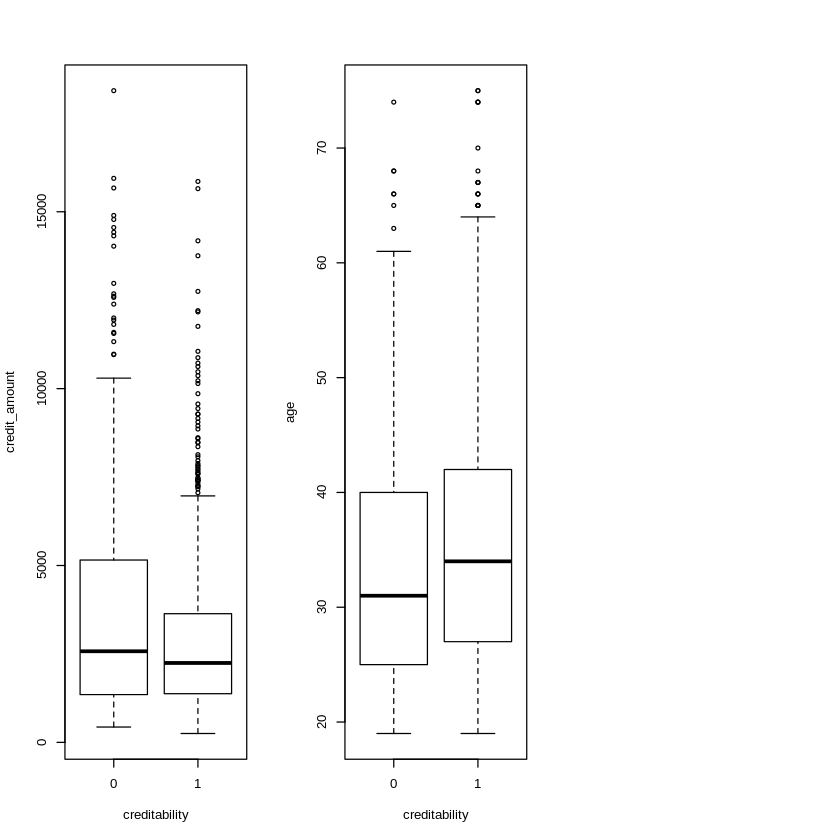

In [3]:
# look at the boxplot of numerical features stratified by creditability
par(mfrow=c(1,3))
plot ( credit_amount     ~ creditability     , data=creditdata)
plot ( age               ~ creditability     , data=creditdata)






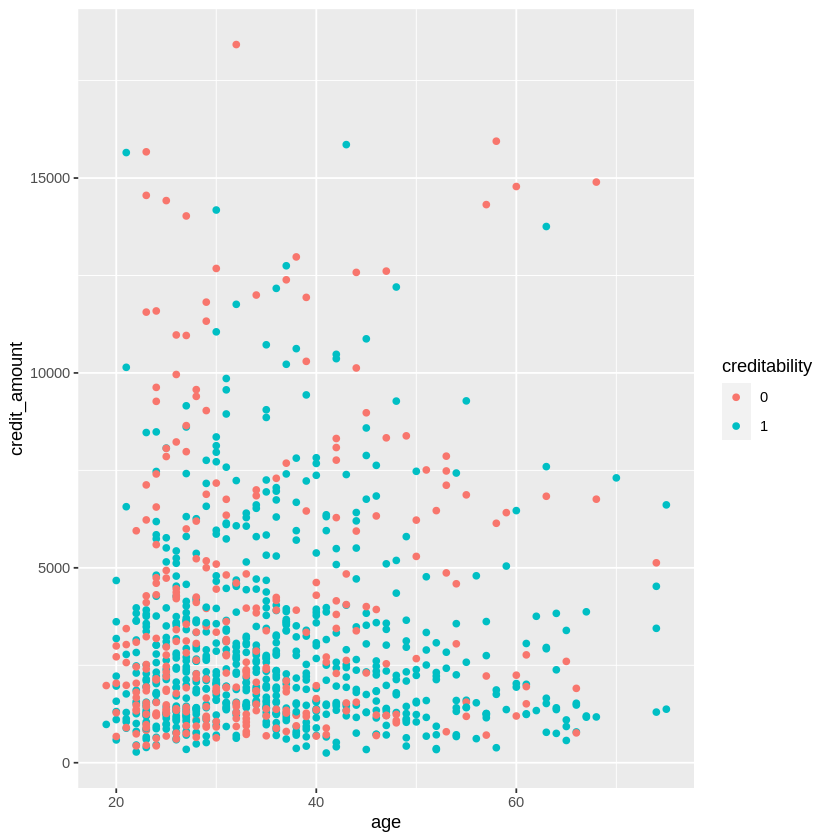

In [4]:
# look at the scatter plot of numerical variables
ggplot(creditdata, aes(x = age, y = credit_amount, color = creditability)) +
  geom_point() +
  labs(x = "age", y = "credit_amount", color = "creditability  ") 


## Data pre-processing
Before conducting knn analysis, we will need to prepare our data: 
- First, we will split data into test and training sets.
- Then, in the second step, we will do  centering and scaling.  For numerical data,  we will need to **center** and **scale** data to prevent differences in unit of measurements to dominate the distance measurement.  
- For categorical features, we will conduct **one-hot encoding** such that there will be one dummy variable for each group of a categorical variable. 

In this lab assignment, we will use  **recipe** function in **recipes** package to pre process the data. **step_center** and **step_scale** functions are used to scale the data and **step_dummy** function to conduct **one-hot encoding**, shown in the next code chunk.   

In [5]:
# Step 1: data splitting with caret package. Hold 30% for testing. 

set.seed(4230) 
row_index <- createDataPartition(creditdata$creditability, p = 0.7,
list = FALSE)
train_set <- creditdata[row_index, ]  # name training set
test_set <- creditdata[-row_index, ]   # name the test set




# steps 2 and 3
# some cleaning with recipe function. do the pre processing on the train_set
 
features_train <- recipe(creditability  ~ ., data = creditdata) %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes())%>%
step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE) %>%
prep(training = train_set, retain = TRUE) %>%
juice() %>%
  select(-creditability)


# some cleaning with recipe function. do the pre processing on the test_set
features_test <- recipe(creditability  ~ ., data = creditdata) %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes())%>%
step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE) %>%
prep(training = test_set, retain = TRUE) %>%
juice() %>%
  select(-creditability)




# In the original data, we had two numerical and two categorical variables:
#payment_status with 5 classes and sex_marital with 4 classes
#With one-hot encoding, payment_status variable is  splitted into five dummies

# And sex_marital   variable is splitted into four dummy variables 
# In total, we ended up with 11 features
# 'credit_amount''age''payment_status_X0''payment_status_X1''payment_status_X2''payment_status_X3''payment_status_X4''sex_marital_X1''sex_marital_X2''sex_marital_X3''sex_marital_X4'

In [6]:
# check the dimension of the features 
# With one hot encoding, instead of four , we now have eleven predictors
print(dim(features_train))

# check the summary statistics of features
print(summary(features_train))

[1] 700  11
 credit_amount          age          payment_status_X0 payment_status_X1
 Min.   :-1.0458   Min.   :-1.4593   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:-0.6637   1st Qu.:-0.7477   1st Qu.:0.00000   1st Qu.:0.00000  
 Median :-0.3569   Median :-0.2140   Median :0.00000   Median :0.00000  
 Mean   : 0.0000   Mean   : 0.0000   Mean   :0.03857   Mean   :0.04857  
 3rd Qu.: 0.2382   3rd Qu.: 0.4976   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   : 5.1357   Max.   : 3.5219   Max.   :1.00000   Max.   :1.00000  
 payment_status_X2 payment_status_X3 payment_status_X4 sex_marital_X1   
 Min.   :0.0000    Min.   :0.00000   Min.   :0.0000    Min.   :0.00000  
 1st Qu.:0.0000    1st Qu.:0.00000   1st Qu.:0.0000    1st Qu.:0.00000  
 Median :1.0000    Median :0.00000   Median :0.0000    Median :0.00000  
 Mean   :0.5386    Mean   :0.07857   Mean   :0.2957    Mean   :0.05714  
 3rd Qu.:1.0000    3rd Qu.:0.00000   3rd Qu.:1.0000    3rd Qu.:0.00000  
 Max.   :1.0000    Max.   :1.00000   Ma

## knn approach
Knn approach is not good at handling missing values.  Luckily, there is no missing value in our dataset and it can be checked with the following line of code: 
**sapply(creditdata, function(x) sum(is.na(x)))**

We will use **knn** function in **class** package to get the label predictions. 


First, for illustration purposes, we will select one data point from the test set, calculate the distance to each observation in the training data set and look at the closest observations and their corresponding labels. Distance is a measure of dissimilarity, the closer the distance between two observations, the higher the similarity. This is just a practice to help you understand the algorithm behind knn. 

First, we will use **dist()** function in R and calculate the Manhattan distance between the first observation in the test set and each observation in the training set. Since we need all numerical variables to be scaled and categorical variables to be hot-encoding, we will use  **features_train** and **features_test** for distance measurement. 


 
 We take the first observation in test data (we name it as test1 below) and calculate the pairwise distances for each observation in the train set and later collect them in a data frame along with the train data labels and call it **collect**.
 
 In  **collect**, the first column **train_label** shows the data label in train data set. The second column **distance** shows the Manhattan distance from the first observation in the test data set and each observation in the train dataset.  
 
       


In [7]:
test1<-features_test[1,]  # this is the first observation in test data

combine <- rbind(test1,features_train)  # stack test1 and train data feaures, test1 being the first row

distanceALL<-as.matrix(dist(combine, method = "manhattan"))  # calculate distance from each row in combine against all other rows and save it as a matrix
collect<-cbind(as.data.frame(train_set$creditability),distanceALL[2:701,1]) # combine train_set labels with the distance measure
names<-c('train_label','distance')
names(collect) <-names
head(collect)  # list the first few observations in collect

collect<-as.data.frame(collect)

,train_label,distance
,<fct>,<dbl>
2,1,3.9301694
3,1,5.8230155
4,1,0.4738137
5,1,1.3395091
6,1,0.4699036
7,1,0.9272197


In [8]:

Nine_neighbors <- head(sort(collect$distance, decreasing = FALSE,), n=9)
print(Nine_neighbors)

[1] 0.05748176 0.11378517 0.12875088 0.16121630 0.16974302 0.23162823 0.23945121
[8] 0.27807582 0.29251147


## Exercise 1

Sort **collect** based on **distance** in ascending order (from lowest to highest) and only show the first 9 rows and call it **Nine_neighbors**. 


In [9]:

# Exercise #1:  List the Nine_neighbors

# your code here (arrange)

Nine_neighbors <- head(arrange(collect,(distance)), n = 9)
print(Nine_neighbors)

  train_label   distance
1           1 0.05748176
2           1 0.11378517
3           1 0.12875088
4           1 0.16121630
5           1 0.16974302
6           1 0.23162823
7           1 0.23945121
8           1 0.27807582
9           1 0.29251147


In [10]:
# Test your code in here
### BEGIN HIDDEN TEST


test_that("Check distance measures", {
    expect_equal( min(Nine_neighbors$distance),0.0574817558633449)})

test_that("Check distance measures", {
    expect_equal( max(Nine_neighbors$distance),0.29251146576787)})


test_that("Check distance measures", {
    expect_equal( mean(Nine_neighbors$distance),0.185849316164428)})
        
print("Passed!")

### END HIDDEN TEST

[1] "Passed!"


## Exercise 2

Use **knn** function in **class** package and predict labels in the test data with knn when k=5. Use **set.seed(4230)** and name the predicted  test data labels  as **knn_five**. (**knn_five** is a vector of length 300)   

Please note than knn() function in the class package requires predictors and labels to be entered separately. More specifically, predictors need to be a matrix and the label to be a vector only. Hence,  you need to feed the knn() function with  **features_train** and **train_set$creditability** where the former is in matrix format and the latter is a vector. 



In [11]:
class_error = function(actual, predicted) {
  mean(actual != predicted)
}

In [12]:
y_train <- train_set$creditability
y_test  <- test_set$creditability

y_test

[1] 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0
[186] 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[223] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[260] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[297] 0 0 0 0
Levels: 0 1

In [13]:

# Exercise #2: knn results when k=5

# your code here 

y_train <- train_set$creditability
y_test  <- test_set$creditability


set.seed(4230)
knn_five<-knn(train = features_train, 
         test  = features_test, 
         cl    = y_train, 
         k     = 5)

## Pre process train data from Practice
## labels in test and train set
## train, test, cl (class or labels), k



In [14]:
# Test your code in here
### BEGIN HIDDEN TEST
class_error = function(actual, predicted) {
  mean(actual != predicted)
}

test_that("Check the classification error", {
    expect_equal( class_error(test_set$creditability,knn_five),0.353333333333333)})
        
print("Passed!")

### END HIDDEN TEST

[1] "Passed!"


## Exercise 3

Use **knn** function in **class** package and predict labels in the test data with knn when k=10. Use **set.seed(4230)** and name the predicted  test data labels  as **knn_ten**. (**knn_ten** is a vector of length 300)   

Please note than knn() function in class package requires predictors and labels to be entered separately. More specifically, predictors need to be a matrix and the label to be a vector only. Hence,  you need to feed the knn() function with  **features_train** and **train_set$creditability** where the former is in matrix format and the latter is a vector. 


In [15]:
# Exercise #3: knn results when k=10

# your code here
set.seed(4230)
knn_ten<-knn(train = features_train, 
         test  = features_test, 
         cl    = y_train, 
         k     = 10)
## Pre process train data from Practice
## labels in test and train set
## train, test, cl (class or labels), k

In [16]:
# Test your code in here
### BEGIN HIDDEN TEST
class_error = function(actual, predicted) {
  mean(actual != predicted)
}

test_that("Check the classification error", {
    expect_equal( class_error(test_set$creditability,knn_ten),0.323333333333333)})
        
print("Passed!")

### END HIDDEN TEST

[1] "Passed!"


## Exercise 4:  Performance Measure
This time, we will take the predicted results based on **knn_ten** above and by using the confusion matrix, we will calculate several misclassification measures. Note that if someone has good credit,  creditability=1, we define it as a positive event. For instance, True Negative (TN) refers to cases where the true label (creditability) is 0, and our model predicts it as 0. Likewise, False Negative (FN) refers to cases where true label was 1 (good credit), but the model predicted to be 0. 

**measure** is a 4X2 matrix: the first column stores the performance measure names. Your task is to calculate each performance measure and enter your findings in the second column of measure.  **IMPORTANT:**  You need to enter your findings with two decimal points for the test to pass.  
- For instance, if your performance measure is 0.27777777777777,  enter as 0.28.
- For instance, if your performance measure is 0.4839123412342,  enter as 0.48.


In [19]:
# create a table to record model performance 
nam<-c("Accuracy", "Precision", "Sensitivity","Specificity", " "," "," "," ")  # name the rows
measure<-matrix(nam, nrow=4, ncol=2, byrow=FALSE)     # create a 4X2 matrix



In [20]:
measure

Accuracy,
Precision,
Sensitivity,
Specificity,


In [21]:
# Exercise #4: Performance measure

# your code here
## confusion matrix - table function (will give you a frequency table)

measure[1,2]<-0.68
measure[2,2]<-0.73
measure[3,2]<-0.85
measure[4,2]<-0.28


In [22]:
# Test your code in here
### BEGIN HIDDEN TEST

test_that("Check the results", {
    expect_equal(as.numeric(measure[1,2])*as.numeric(measure[2,2])*as.numeric(measure[3,2]) ,0.42194
)})


test_that("Check the results", {
    expect_equal(as.numeric(measure[3,2])*as.numeric(measure[4,2]) ,0.238

)})

        
print("Passed!")



### END HIDDEN TEST

[1] "Passed!"


## Parameter Tuning

In knn, k is the only parameter we need to tune to find the optimal k. Next, we try k values from 1 to 50, and calculate the classification error for each k and save them as **k_class_error**. 


In [23]:
set.seed(4230)
k_values = 1:50
k_class_error = seq(0,0,length.out=length(k_values))

for (i in seq_along(k_values)) {
  predicted_labels =  knn(train = features_train, 
         test  = features_test, 
         cl    = train_set$creditability, 
         k     =k_values[i] )
  k_class_error[i] = class_error(test_set$creditability, predicted_labels)
}

print(k_class_error)

 [1] 0.3600000 0.3666667 0.3366667 0.3633333 0.3533333 0.3266667 0.3466667
 [8] 0.3433333 0.3400000 0.3366667 0.3300000 0.3466667 0.3033333 0.3133333
[15] 0.3033333 0.3000000 0.3100000 0.2966667 0.3100000 0.3100000 0.3033333
[22] 0.3066667 0.2966667 0.2900000 0.2966667 0.3133333 0.2933333 0.2933333
[29] 0.2866667 0.2866667 0.2866667 0.2800000 0.2900000 0.2900000 0.2933333
[36] 0.2900000 0.2900000 0.2900000 0.2900000 0.3000000 0.2933333 0.2966667
[43] 0.2900000 0.2966667 0.2933333 0.2933333 0.2933333 0.2900000 0.2900000
[50] 0.2966667


## Exercise 5:
 Write a function to find the optimal k  (the k value which minimizes the classification error) and call it **optimal_k**.  In other words, at which value of **k** does the **k_class_error** take the minimum value?

In [26]:
# Exercise #5: find the optimal k

# your code here

optimal_k <- which(k_class_error == min(k_class_error))

In [27]:
# Test your code in here
### BEGIN HIDDEN TEST

test_that("Check the optimal k", {
    expect_equal( optimal_k/4,8)})
        
print("Passed!")


### END HIDDEN TEST


[1] "Passed!"


## Cross validation
A better approach to find the optimal k is cross-validation.  One can use caret package to conduct k-fold cross validation very easily. Since the Coursera platform does not support certain packages in the Lab Manager, we skipped the cross-validation part. 